/home/purzelrakete/src/github.com/feldberlin/deepspeech/.venv/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
/home/purzelrakete/src/github.com/feldberlin/deepspeech/.venv/lib/python3.7/site-packages/torchaudio/compliance/kaldi.py:574: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  fft = torch.rfft(strided_input, 1, normalized=False, onesided=True)


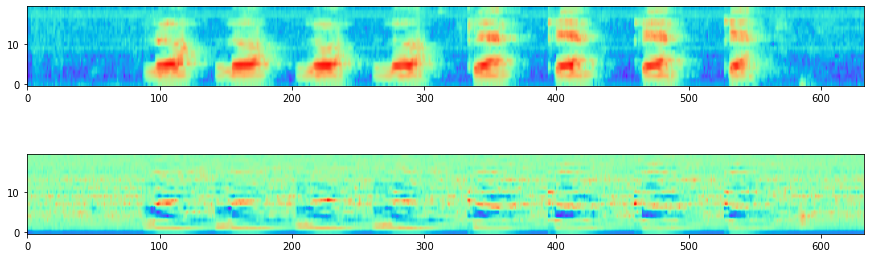

In [1]:
import torchaudio
yesno_raw = torchaudio.datasets.YESNO('.', download=True)

# Let's see what the spectrogram looks like
fbank = torchaudio.compliance.kaldi.fbank(yesno_raw[0][0], sample_frequency=yesno_raw[0][1], num_mel_bins=20)
mfcc = torchaudio.compliance.kaldi.mfcc(yesno_raw[0][0], sample_frequency=yesno_raw[0][1], num_mel_bins=20, num_ceps=20)
%matplotlib inline
import matplotlib.pyplot as plot
plot.rcParams["figure.figsize"] = (15,5)
plot.subplot(211)
plot.imshow(fbank.transpose(0,1), cmap='rainbow', origin='lower', aspect=3)
plot.subplot(212)
plot.imshow(mfcc.transpose(0,1), cmap='rainbow', origin='lower', aspect=3)

In [2]:
import torchaudio
import numpy as np
from torch.utils.data import Dataset
class YesNoDataset(Dataset):
    def __init__(self, root):
        self.raw = torchaudio.datasets.YESNO(root, download=False)
        self.target_map = [[3, 4], [6, 2, 5]]
        self.left_context = 3
        self.right_context = 3
        self.subsample_factor = 3
        self.max_input_length = 1200
        self.max_target_length = 40

    def __getitem__(self, index):
        wave_form, rate, label = self.raw[index]
        features = torchaudio.compliance.kaldi.mfcc(wave_form, sample_frequency=rate, num_mel_bins=20, num_ceps=20)
        features = self.splice_and_subsample(features)
        targets = self.map_targets(label)

        inputs_length = np.array(features.shape[0]).astype(np.int64)
        targets_length = np.array(targets.shape[0]).astype(np.int64)

        features = self.pad(features, self.max_input_length).astype(np.float32)
        targets = self.pad(targets, self.max_target_length).astype(np.int64).reshape(-1)

        return features, inputs_length, targets, targets_length

    def __len__(self):
        return len(self.raw)

    def splice_and_subsample(self, features):
        time_steps, features_dim = features.shape
        spliced_features = np.zeros(
            shape=[time_steps, features_dim *
                   (1 + self.left_context + self.right_context)],
            dtype=np.float32)
        # middle part is just the uttarnce
        spliced_features[:, self.left_context * features_dim:
                          (self.left_context + 1) * features_dim] = features

        for i in range(self.left_context):
            # add left context
            spliced_features[i + 1:time_steps,
                              (self.left_context - i - 1) * features_dim:
                              (self.left_context - i) * features_dim] = features[0:time_steps - i - 1, :]

        for i in range(self.right_context):
            # add right context
            spliced_features[0:time_steps - i - 1,
                              (self.right_context + i + 1) * features_dim:
                              (self.right_context + i + 2) * features_dim] = features[i + 1:time_steps, :]

        temp_mat = [spliced_features[i] for i in range(0, spliced_features.shape[0], self.subsample_factor)]
        subsampled_features = np.row_stack(temp_mat)
        return subsampled_features
    
    def map_targets(self, label):
        targets = []
        for idx, word in enumerate(label):
            targets.extend(self.target_map[word])
            if (idx < len(label) - 1) : targets.append(1) 
        return np.array(targets)
    
    def pad(self, inputs, max_length):
        dim = len(inputs.shape)
        if dim == 1:
            # padding targets
            pad_zeros_mat = np.zeros([1, max_length - inputs.shape[0]], dtype=np.int32)
            padded_inputs = np.column_stack([inputs.reshape(1, -1), pad_zeros_mat])
        elif dim == 2:
            # padding inputs
            feature_dim = inputs.shape[1]
            pad_zeros_mat = np.zeros([max_length - inputs.shape[0], feature_dim])
            padded_inputs = np.row_stack([inputs, pad_zeros_mat])
        return padded_inputs

In [3]:
yesno_data = YesNoDataset('.')

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
indices = list(range(len(yesno_data)))
# np.random.shuffle(indices)
train_indices, test_indices = indices[:50], indices[50:]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
training_data = DataLoader(yesno_data, batch_size=4, shuffle=False, num_workers=0, sampler=train_sampler)
test_data = DataLoader(yesno_data, batch_size=1, shuffle=False, num_workers=0, sampler=test_sampler)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class CTC(nn.Module):
    def __init__(self):
        super(CTC, self).__init__()
        self.input = nn.Linear(140, 100, bias=True)
        self.rnn = nn.RNN(input_size=100, hidden_size=100, num_layers=1, bidirectional=True, batch_first=True)
        self.output = nn.Linear(200, 7, bias=True)
        self.loss_fn = nn.CTCLoss()

    def forward(self, inputs, inputs_length, targets, targets_length):
        # make inputs and parameters contiguous  
        inputs = self.input(inputs)
        self.rnn.flatten_parameters()
        outputs, _ = self.rnn(inputs)
        logits = self.output(outputs).log_softmax(2)
        logits = logits.transpose(0, 1).contiguous()
        loss = self.loss_fn(logits, targets.int(), inputs_length.int(), targets_length.int())
        return loss

    def recognize(self, inputs):
        dic = ['', ' ', 'E', 'N', 'O', 'S', 'Y']
        if (len(inputs.shape) == 2):
            inputs = torch.unsqueeze(inputs, 0)
        inputs = self.input(inputs)
        outputs, _ = self.rnn(inputs)
        logits = self.output(outputs).softmax(2).detach()
        rdigit = []
        for logit in logits[0]:
            pred = int(torch.argmax(logit, dim=0).item())
            if pred != 0:
                if len(rdigit) > 0 and pred == rdigit[-1]:
                    continue
                rdigit.append(pred)
        result = ''.join([dic[x] for x in rdigit])
        return result, logits

torch.cuda.manual_seed(20200513)
model = CTC()
model = model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.006, momentum=0.9, weight_decay=0)

In [6]:
def train(epoch, model, training_data, optimizer):
    model.train()
    total_loss = 0  # track loss
    for step, (inputs, inputs_length, targets, targets_length) in enumerate(training_data):
        # copy data to gpu device
        inputs, inputs_length = inputs.cuda(), inputs_length.cpu()
        targets, targets_length = targets.cuda(), targets_length.cuda()
        max_inputs_length = inputs_length.max().item()
        max_targets_length = targets_length.max().item()
        inputs = inputs[:, :max_inputs_length, :]
        targets = targets[:, :max_targets_length]

        # real thing
        optimizer.zero_grad()
        loss = model(inputs, inputs_length, targets, targets_length)
        loss = torch.mean(loss)
        loss.backward()
        total_loss += loss.item()
        nn.utils.clip_grad_norm_(model.parameters(), 200)
        optimizer.step()
        avg_loss = total_loss / (step + 1)
    print('epoch {0}: avg_loss {1}'.format(epoch, avg_loss))

In [7]:
for epoch in range(1, 100):
    train(epoch, model, training_data, optimizer)

epoch 1: avg_loss 2.9343284643613377
epoch 2: avg_loss 1.1619638112875132
epoch 3: avg_loss 0.416396269431481
epoch 4: avg_loss 0.20471059129788324
epoch 5: avg_loss 0.15786691926992857
epoch 6: avg_loss 0.11650710323682198
epoch 7: avg_loss 0.0990715021124253
epoch 8: avg_loss 0.08480128760521229
epoch 9: avg_loss 0.08046231648096672
epoch 10: avg_loss 0.0746701520222884
epoch 11: avg_loss 0.07265101373195648
epoch 12: avg_loss 0.07065432432752389
epoch 13: avg_loss 0.06310453566794212
epoch 14: avg_loss 0.05524286498817114
epoch 15: avg_loss 0.05160855630842539
epoch 16: avg_loss 0.04407640489248129
epoch 17: avg_loss 0.040242466932305924
epoch 18: avg_loss 0.03808157432537813
epoch 19: avg_loss 0.03599156339008074
epoch 20: avg_loss 0.03690084227575706
epoch 21: avg_loss 0.029552649420041304
epoch 22: avg_loss 0.029319101084883396
epoch 23: avg_loss 0.029052568742862113
epoch 24: avg_loss 0.025575106605314292
epoch 25: avg_loss 0.025140266650571272
epoch 26: avg_loss 0.0269672352677

In [8]:
test = next(iter(test_data))
model.eval()
result, logits = model.recognize(test[0].cuda())
print(result)

YES YES YES YES YES NO NO NO 


In [9]:
dic = ['', ' ', 'E', 'N', 'O', 'S', 'Y']
label = ''.join([dic[x] for x in test[2][0]])
print(label)

YES YES YES YES YES NO NO NO


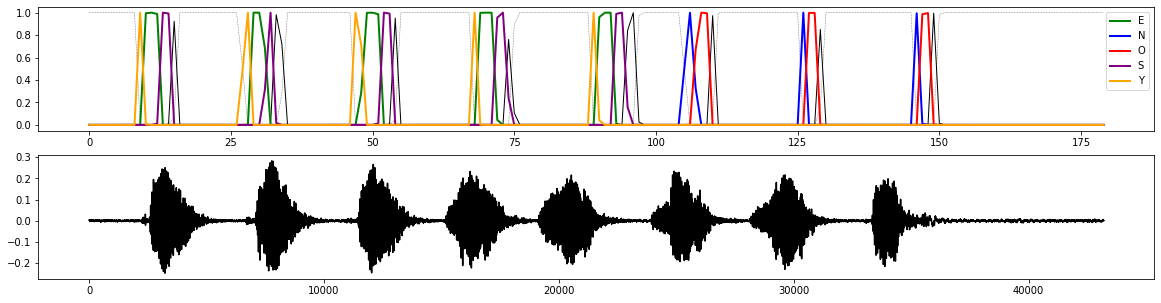

In [10]:
import matplotlib.pyplot as plot
probs = logits[0].transpose(0, 1).cpu().numpy()
show_start = 20
show_end = 200
plot.rcParams["figure.figsize"] = (20,5)
plot.subplot(211)
plot.plot(probs[0][show_start:show_end], '--', color='gray', linewidth=0.5)
plot.plot(probs[1][show_start:show_end], color='black', linewidth=1)
plot.plot(probs[2][show_start:show_end], color='green', linewidth=2, label='E')
plot.plot(probs[3][show_start:show_end], color='blue', linewidth=2, label='N')
plot.plot(probs[4][show_start:show_end], color='red', linewidth=2, label='O')
plot.plot(probs[5][show_start:show_end], color='purple', linewidth=2, label='S')
plot.plot(probs[6][show_start:show_end], color='orange', linewidth=2, label='Y')
plot.legend()
plot.subplot(212)
yesno_raw = torchaudio.datasets.YESNO('.', download=False)
for raw in yesno_raw:
    if raw[2] == [1, 1, 1, 0, 0, 0, 0, 1]:
        wave = raw[0]
        break
plot.plot(wave[0][(show_start*30*8):(show_end*30*8)], color='black')